# Analyzing the impact of Political and Economic Sentiment on Healthcare and Tech stock market Performance in Election Year 2024

## By: Dennis Goldenberg, Kevin Shao, and Samaa Nadkarni

In [48]:
import numpy as np
import pandas as pd
import scipy as sc
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, date
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Reading in the Data

In [2]:
#trump's odds
trump_odds = pd.read_csv("data/Trump_implied_prob_victory_odds.csv")
trump_odds["DATE"] = trump_odds["Date (UTC)"].apply(lambda x: datetime.strptime(x,
                                                          '%m-%d-%Y 00:00').date())
trump_odds.drop(columns = ["Date (UTC)","Timestamp (UTC)"], inplace = True)
trump_odds.rename({"Price": "trump_odds"}, axis = 1,inplace = True)

#t-bills 2 Year
tbills_2Y = pd.read_csv("data/Tbills_2Y_mkt_yield.csv")
tbills_2Y['DATE'] = tbills_2Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_2Y['DGS2'] = tbills_2Y['DGS2'].astype(float)

#t-bills 10 Year
tbills_10Y = pd.read_csv("data/Tbills_10Y_mkt_yield.csv")
tbills_10Y['DATE'] = tbills_10Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_10Y['DGS10'] = tbills_2Y['DGS10'].astype(float)

#Other Project Data
other_data = pd.read_csv("data/Project Data V1.csv")
other_data["DATE"] = other_data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
other_data.drop(columns = ['date', 'Gold_Price', 'Oil_Price','Gold_Volume',
                           'Oil_Volume'], inplace = True)

#Continue merging procedure
result_Frame = pd.merge(left = pd.merge(left = pd.merge(left = tbills_2Y, 
                                         right = tbills_10Y, 
                                         on = 'DATE'),
                right = trump_odds,
                on = 'DATE'),
         right = other_data,
         on = 'DATE')

In [3]:
columns = np.append(result_Frame.columns.values[-9], 
          np.append(result_Frame.columns.values[-5:-3],
          np.append(result_Frame.columns.values[-8:-5],
                    result_Frame.columns.values[-3:])))
raw_data = result_Frame.copy()[columns]

## Linearly interpolating to fill in missing gaps on market yield Time Series

In [4]:
def interp(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if array_vals[i] == '.':
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

def interp2(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if ~(array_vals[i] > 0):
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

In [5]:
raw_data['DGS2'] = interp(raw_data['DATE'], raw_data['DGS2'])
raw_data['DGS10'] = interp(raw_data['DATE'], raw_data['DGS10'])
raw_data['BEIR'] = interp2(raw_data['DATE'], raw_data['BEIR'])

In [6]:
raw_data[raw_data.columns.values[1:]].corr()
#Dollar Index and BEIR closely correlated, likely will use BEIR, we will keep this in mind

,NASDAQ 100 Tech Index,S&P Healthcare Index,DGS2,DGS10,trump_odds,Dollar_Index,BEIR,VIX index
NASDAQ 100 Tech Index,1.000000,0.269505,0.113331,0.137348,0.578086,0.189297,0.136811,-0.327581
S&P Healthcare Index,0.269505,1.000000,-0.781413,-0.724043,0.182827,-0.684011,-0.686965,0.402273
DGS2,0.113331,-0.781413,1.000000,0.920299,-0.034817,0.868550,0.758589,-0.541470
DGS10,0.137348,-0.724043,0.920299,1.000000,0.032334,0.902646,0.877826,-0.359944
trump_odds,0.578086,0.182827,-0.034817,0.032334,1.000000,0.179487,0.014218,0.012486
Dollar_Index,0.189297,-0.684011,0.868550,0.902646,0.179487,1.000000,0.729285,-0.316556
BEIR,0.136811,-0.686965,0.758589,0.877826,0.014218,0.729285,1.000000,-0.332449
VIX index,-0.327581,0.402273,-0.541470,-0.359944,0.012486,-0.316556,-0.332449,1.000000


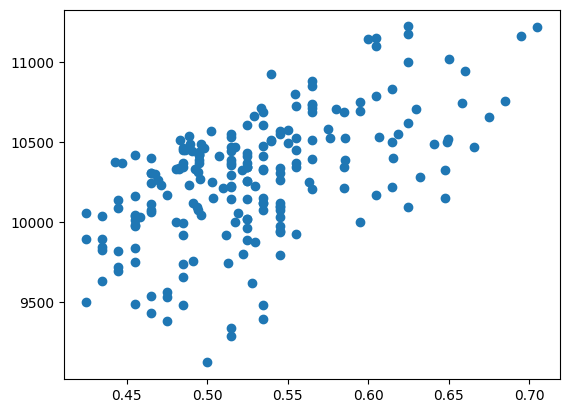

In [7]:
plt.scatter(raw_data['trump_odds'], raw_data['NASDAQ 100 Tech Index'])
plt.show()

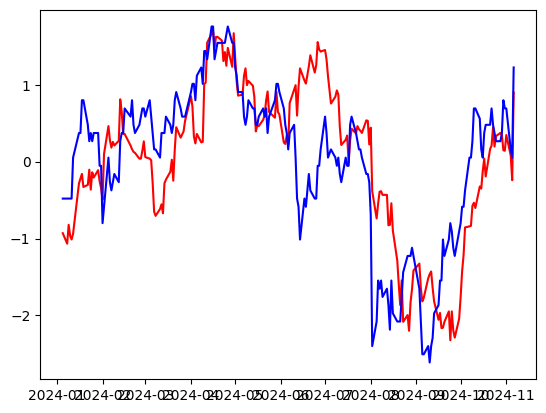

In [8]:
plt.plot(raw_data['DATE'], (raw_data['Dollar_Index'] - np.mean(raw_data['Dollar_Index']))/np.std(raw_data['Dollar_Index']), color = 'red')
plt.plot(raw_data['DATE'], (raw_data['BEIR'] - np.mean(raw_data['BEIR']))/np.std(raw_data['BEIR']), color = 'blue')
plt.show()

# Data Preprocessing

## Examining Stationarity

### Stationarity of Response

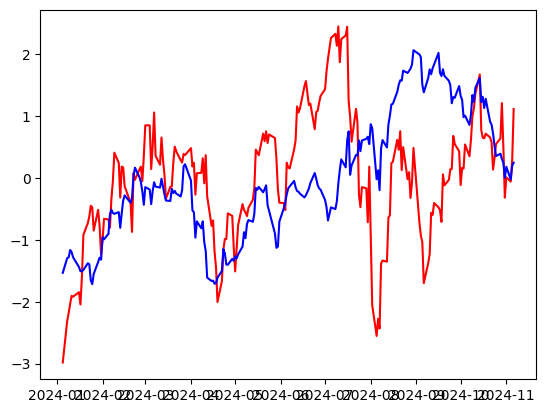

In [9]:
plt.plot(raw_data['DATE'], 
         (raw_data['NASDAQ 100 Tech Index'] - np.mean(raw_data['NASDAQ 100 Tech Index']))/np.std(raw_data['NASDAQ 100 Tech Index']),
          color = 'red')
plt.plot(raw_data['DATE'], 
         (raw_data['S&P Healthcare Index'] - np.mean(raw_data['S&P Healthcare Index']))/np.std(raw_data['S&P Healthcare Index']),
          color = 'blue')
plt.show()

In [10]:
#Stationarity Analysis
test_1 = adfuller(raw_data['NASDAQ 100 Tech Index'])
print(f'ADF Statistic: {test_1[0]}')
print(f'p-value: {test_1[1]}')
for key, value in test_1[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.6618042395485575
p-value: 0.004683641110341457
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [11]:
test_2 = adfuller(raw_data['S&P Healthcare Index'])
print(f'ADF Statistic: {test_2[0]}')
print(f'p-value: {test_2[1]}')
for key, value in test_2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8250689818757204
p-value: 0.36808856903608234
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


So, according to the ADF test, the S&P Healthcare index isn't stationary, but the NASDAQ 100 tech index is. I difference the S&P Healthcare Index series and than model again:

In [12]:
differenced_healthcare = raw_data['S&P Healthcare Index'][1:].values - raw_data['S&P Healthcare Index'][0:(len(raw_data['S&P Healthcare Index']) - 1)]
test_3 = adfuller(differenced_healthcare)
print(f'ADF Statistic: {test_3[0]}')
print(f'p-value: {test_3[1]}')
for key, value in test_3[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.494243130073329
p-value: 6.077736548238598e-27
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


In [13]:
differenced_tech = raw_data['NASDAQ 100 Tech Index'][1:].values - raw_data['NASDAQ 100 Tech Index'][0:(len(raw_data['NASDAQ 100 Tech Index']) - 1)]
test_4 = adfuller(differenced_tech)
print(f'ADF Statistic: {test_4[0]}')
print(f'p-value: {test_4[1]}')
for key, value in test_4[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -15.043350265217933
p-value: 9.522285814237057e-28
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


### Stationarity of Covariates

In [14]:
test_5 = adfuller(raw_data['trump_odds'])
print(f'ADF Statistic: {test_5[0]}')
print(f'p-value: {test_5[1]}')
for key, value in test_5[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.1416710698316237
p-value: 0.02361913682441857
Critial Values:
   1%, -3.4633090972761744
Critial Values:
   5%, -2.876029332045744
Critial Values:
   10%, -2.5744932593252643


In [15]:
differenced_trump = raw_data['trump_odds'][1:].values - raw_data['trump_odds'][0:(len(raw_data['trump_odds']) - 1)].values
test_6 = adfuller(differenced_trump)
print(f'ADF Statistic: {test_6[0]}')
print(f'p-value: {test_6[1]}')
for key, value in test_6[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.359652808750078
p-value: 4.114822851841194e-06
Critial Values:
   1%, -3.4624988216864776
Critial Values:
   5%, -2.8756749365852587
Critial Values:
   10%, -2.5743041549627677


In [16]:
test_7 = adfuller(raw_data['BEIR'])
print(f'ADF Statistic: {test_7[0]}')
print(f'p-value: {test_7[1]}')
for key, value in test_7[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.871810865599115
p-value: 0.3454361203435057
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [17]:
differenced_BEIR = raw_data['BEIR'][1:].values - raw_data['BEIR'][0:(len(raw_data['BEIR']) - 1)].values
test_8 = adfuller(differenced_BEIR)
print(f'ADF Statistic: {test_8[0]}')
print(f'p-value: {test_8[1]}')
for key, value in test_8[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.383281914055717
p-value: 4.9293536345364505e-25
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


In [18]:
test_9 = adfuller(raw_data['VIX index'])
print(f'ADF Statistic: {test_9[0]}')
print(f'p-value: {test_9[1]}')
for key, value in test_9[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.781259752742012
p-value: 0.0031049783628894208
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [19]:
differenced_VIX = raw_data['VIX index'][1:].values - raw_data['VIX index'][0:(len(raw_data['VIX index']) - 1)].values
test_10 = adfuller(differenced_VIX)
print(f'ADF Statistic: {test_10[0]}')
print(f'p-value: {test_10[1]}')
for key, value in test_10[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -16.43789131833375
p-value: 2.4435037086827976e-29
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


We do this differencing so that, when doing cross correlation analysis, we actually get real relationships, not relationships of variables with themselves. I difference all variables with a p value less than .05:

In [31]:
result_data = raw_data[['DATE', 'S&P Healthcare Index', 'NASDAQ 100 Tech Index',
                        'trump_odds', 'BEIR', 'VIX index']][1:].copy()
result_data.reset_index(inplace = True, drop = True)
result_data['S&P Healthcare Index'] = differenced_healthcare
#result_data['NASDAQ 100 Tech Index'] = differenced_tech
#result_data['trump_odds'] = differenced_trump
result_data['BEIR'] = differenced_BEIR
#result_data['VIX index'] = difference_VIX
result_data

,DATE,S&P Healthcare Index,NASDAQ 100 Tech Index,trump_odds,BEIR,VIX index
0,2024-01-08,13.640015,9382.04,0.4750,0.00,13.080000
1,2024-01-09,0.670044,9431.27,0.4650,0.00,12.760000
2,2024-01-10,6.809937,9488.72,0.4550,0.00,12.690000
3,2024-01-11,-1.859985,9539.06,0.4650,0.00,12.440000
4,2024-01-12,-4.829956,9534.17,0.4750,0.05,12.700000
...,...,...,...,...,...,...
206,2024-10-31,-14.000000,10154.19,0.6475,-0.01,23.160000
207,2024-11-01,10.170044,10281.37,0.6325,0.00,21.879999
208,2024-11-04,-11.760010,10254.28,0.5635,-0.05,21.980000
209,2024-11-05,12.829956,10391.54,0.5855,-0.01,20.490000


## Cross correlelograms

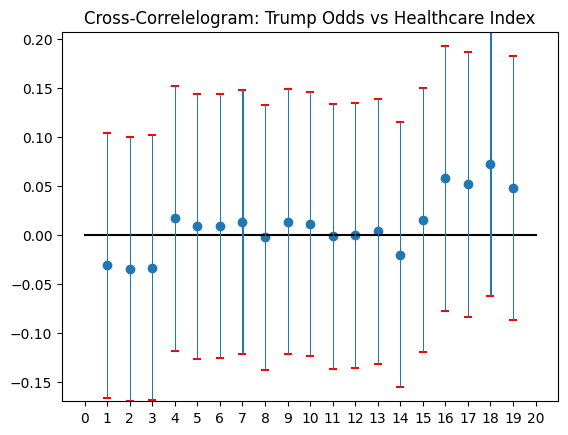

In [21]:
health_trump = ccf(result_data['S&P Healthcare Index'], result_data['trump_odds'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], health_trump[0][1:20])
ax.scatter([i for i in range(1,20)], health_trump[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], health_trump[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_trump[1][:,0][1:20])
top_lim = max(health_trump[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_trump[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_trump[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: Trump Odds vs Healthcare Index")
plt.show()

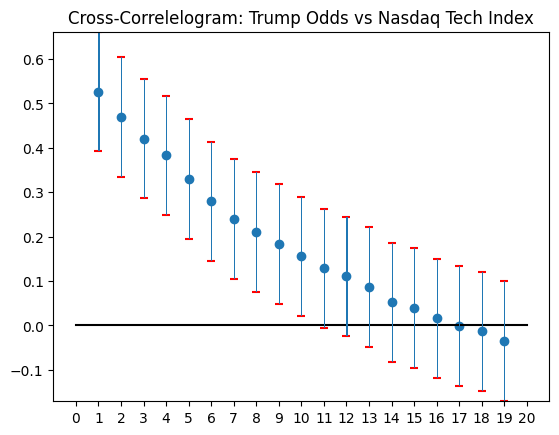

In [22]:
tech_trump = ccf(result_data['NASDAQ 100 Tech Index'], result_data['trump_odds'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], tech_trump[0][1:20])
ax.scatter([i for i in range(1,20)], tech_trump[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], tech_trump[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(tech_trump[1][:,0][1:20])
top_lim = max(tech_trump[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_trump[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_trump[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: Trump Odds vs Nasdaq Tech Index")
plt.show()

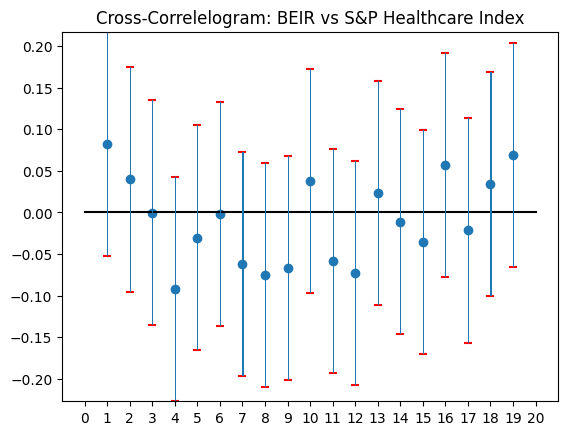

In [23]:
health_BEIR = ccf(result_data['S&P Healthcare Index'], result_data['BEIR'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], health_BEIR[0][1:20])
ax.scatter([i for i in range(1,20)], health_BEIR[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], health_BEIR[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_BEIR[1][:,0][1:20])
top_lim = max(health_BEIR[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_BEIR[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_BEIR[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: BEIR vs S&P Healthcare Index")
plt.show()

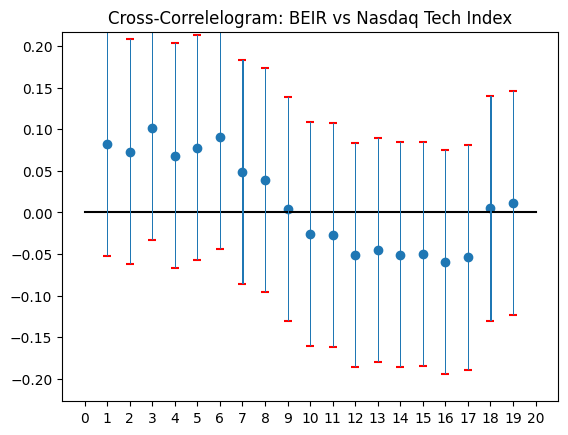

In [24]:
tech_BEIR = ccf(result_data['NASDAQ 100 Tech Index'], result_data['BEIR'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], tech_BEIR[0][1:20])
ax.scatter([i for i in range(1,20)], tech_BEIR[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], tech_BEIR[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_BEIR[1][:,0][1:20])
top_lim = max(health_BEIR[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_BEIR[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_BEIR[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: BEIR vs Nasdaq Tech Index")
plt.show()

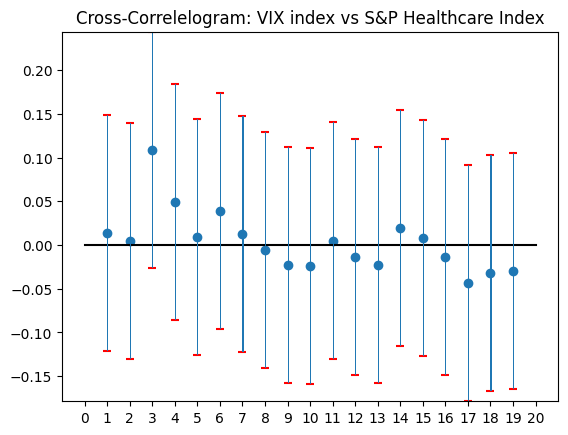

In [25]:
health_VIXIndex = ccf(result_data['S&P Healthcare Index'], result_data['VIX index'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], health_VIXIndex[0][1:20])
ax.scatter([i for i in range(1,20)], health_VIXIndex[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], health_VIXIndex[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_VIXIndex[1][:,0][1:20])
top_lim = max(health_VIXIndex[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_VIXIndex[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_VIXIndex[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: VIX index vs S&P Healthcare Index")
plt.show()

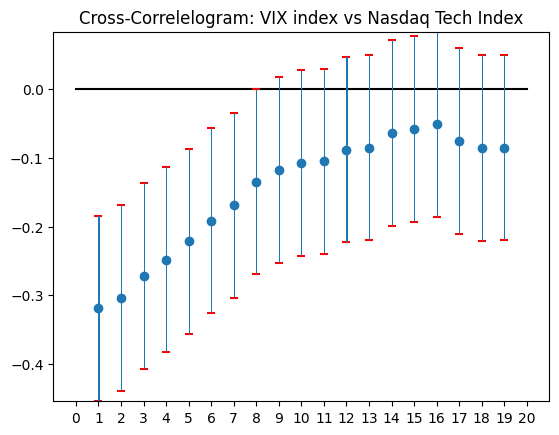

In [26]:
tech_VIXIndex = ccf(result_data['NASDAQ 100 Tech Index'], result_data['VIX index'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(1, 20)], tech_VIXIndex[0][1:20])
ax.scatter([i for i in range(1,20)], tech_VIXIndex[1][:,1][1:20], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(1,20)], tech_VIXIndex[1][:,0][1:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(tech_VIXIndex[1][:,0][1:20])
top_lim = max(tech_VIXIndex[1][:,1][1:20])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(1,20):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_VIXIndex[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_VIXIndex[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, 20), [0] * len(np.linspace(0, 20)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, 21)])
ax.set_title("Cross-Correlelogram: VIX index vs Nasdaq Tech Index")
plt.show()

## Time Series Analysis

### 1. Nasdaq Tech Index


<Figure size 1200x600 with 0 Axes>

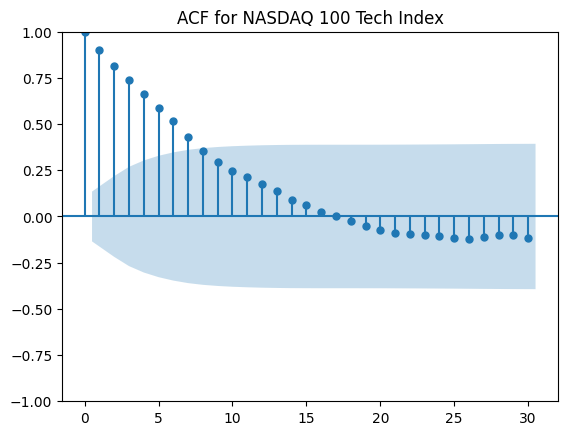

<Figure size 1200x600 with 0 Axes>

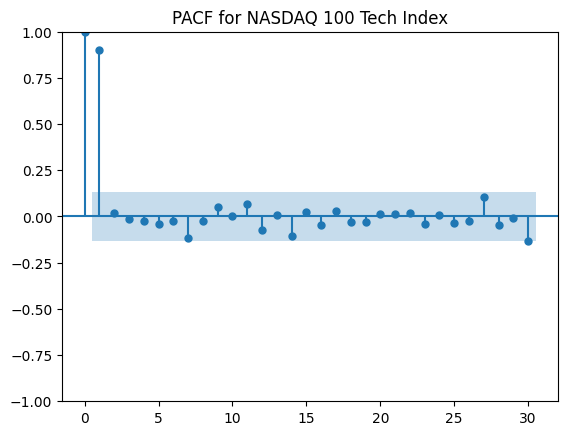

In [27]:
result_data['DATE'] = pd.to_datetime(result_data['DATE'])
result_data.set_index('DATE', inplace=True)
result_data.sort_index(inplace=True)

y = result_data['NASDAQ 100 Tech Index']

plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, title="ACF for NASDAQ 100 Tech Index")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, title="PACF for NASDAQ 100 Tech Index")
plt.show()

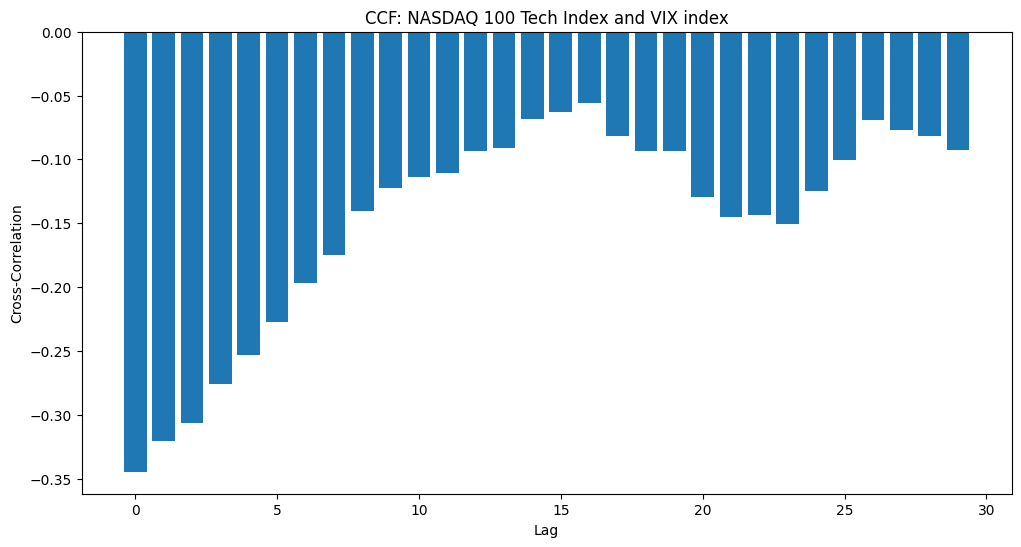

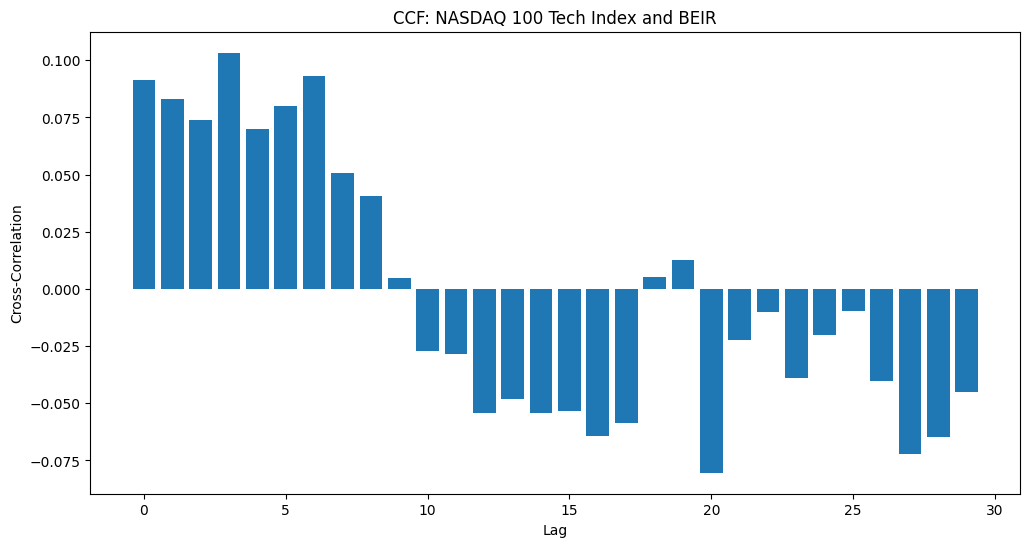

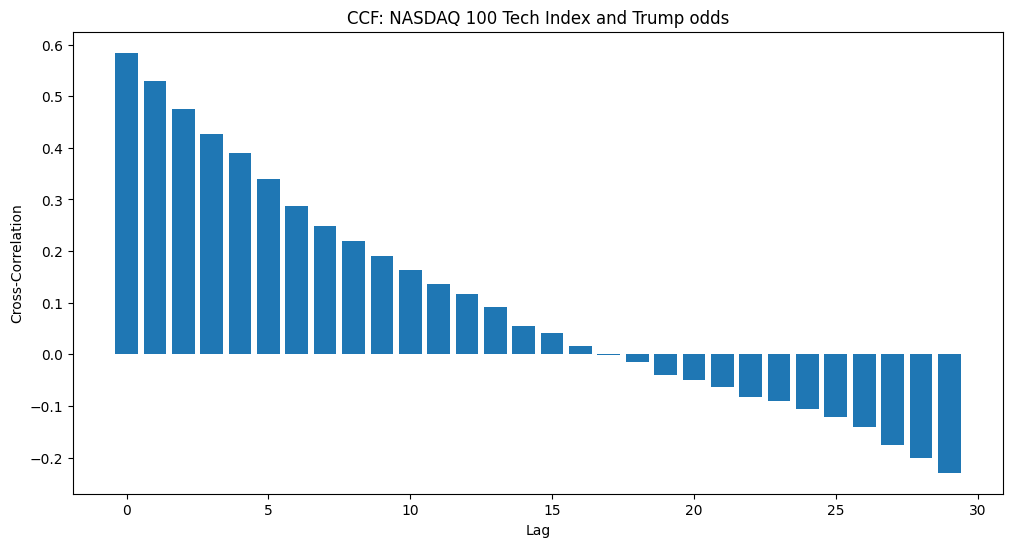

In [28]:
vix = result_data['VIX index']
beir = result_data['BEIR']
trump_odds = result_data['trump_odds']

def plot_ccf(y, x, title):
    cross_corr = ccf(y, x)[:30]  
    lags = range(len(cross_corr))
    plt.figure(figsize=(12, 6))
    plt.bar(lags, cross_corr)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Cross-Correlation")
    plt.show()

plot_ccf(y, vix, "CCF: NASDAQ 100 Tech Index and VIX index")
plot_ccf(y, beir, "CCF: NASDAQ 100 Tech Index and BEIR")
plot_ccf(y, trump_odds, "CCF: NASDAQ 100 Tech Index and Trump odds")

For Tech Index Based on the ACF and PACF plots:
AR (p): 1 (from the significant spike at lag 1 in the PACF).
MA (q): 1 or 2 (from the gradual decay in the ACF).
Differencing (d): 0 (since the data appears stationary, confirmed if the DF test also suggests stationarity).
Thus, an ARIMA(1, 0, 1) or ARIMA(1, 0, 2) model would be good candidates for testing.


Explanatory Variable	 Lags
VIX index	            Lag 0
BEIR	                Lags 1, 2, 3
Trump odds	            Lags 0, 1, 2

With explanatory variable lags fixed, we first run ARIMA(1,0,2)

In [ ]:
y = result_data['NASDAQ 100 Tech Index']
result_data['BEIR_lag1'] = result_data['BEIR'].shift(1)
result_data['BEIR_lag2'] = result_data['BEIR'].shift(2)
result_data['BEIR_lag3'] = result_data['BEIR'].shift(3)
result_data['Trump_odds_lag0'] = result_data['trump_odds']
result_data['Trump_odds_lag1'] = result_data['trump_odds'].shift(1)
result_data['Trump_odds_lag2'] = result_data['trump_odds'].shift(2)
result_data['VIX_lag0'] = result_data['VIX index']
result_data = result_data.dropna()


In [41]:
y_aligned = result_data['NASDAQ 100 Tech Index']
X_aligned = result_data[['BEIR_lag1', 'BEIR_lag2', 'BEIR_lag3', 'Trump_odds_lag0', 'Trump_odds_lag1', 'Trump_odds_lag2', 'VIX_lag0']]

train_size = int(len(result_data) * 0.8)
y_train = y_aligned[:train_size]
y_test = y_aligned[train_size:]
X_train = X_aligned[:train_size]
X_test = X_aligned[train_size:]

In [44]:
model = ARIMA(y_train, order=(1, 0, 2), exog=X_train)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Li

                                 SARIMAX Results                                 
Dep. Variable:     NASDAQ 100 Tech Index   No. Observations:                  166
Model:                    ARIMA(1, 0, 2)   Log Likelihood               -1046.709
Date:                   Mon, 02 Dec 2024   AIC                           2117.418
Time:                           16:59:23   BIC                           2154.762
Sample:                                0   HQIC                          2132.576
                                   - 166                                         
Covariance Type:                     opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9102.6346    510.311     17.837      0.000    8102.443    1.01e+04
BEIR_lag1        -169.4416    504.801     -0.336      0.737   -1158.833     819.950
BEIR_lag

In [45]:
y_test_pred = model_fit.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")

Test Mean Squared Error (MSE): 166329.62796070392


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


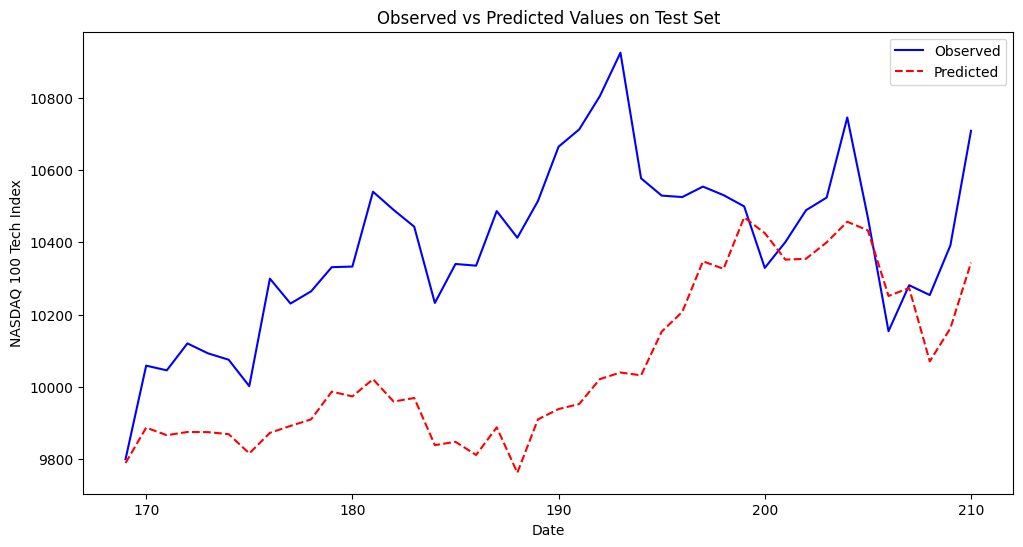

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Observed', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.title('Observed vs Predicted Values on Test Set')
plt.xlabel('Date')
plt.ylabel('NASDAQ 100 Tech Index')
plt.legend()
plt.show()

Residual Test to see if we have captured patterns and the remaining is white noise

In [ ]:
residuals = model_fit.resid

ljung_box_results = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

for lag, p_value in zip(ljung_box_results.index, ljung_box_results['lb_pvalue']):
    if p_value > 0.05:
        print(f"At lag {lag}, residuals appear to be white noise.")
    else:
        print(f"At lag {lag}, residuals do not appear to be white noise.")

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   7.997831   0.629049
15   9.322772   0.860045
20  12.548929   0.895889
At lag 10, residuals appear to be white noise.
At lag 15, residuals appear to be white noise.
At lag 20, residuals appear to be white noise.


With explanatory variable lags fixed, we first run ARIMA(1,0,2)

In [52]:
arima_101_model = ARIMA(y_train, order=(1, 0, 1), exog=X_train)
arima_101_fit = arima_101_model.fit()
print(arima_101_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     NASDAQ 100 Tech Index   No. Observations:                  166
Model:                    ARIMA(1, 0, 1)   Log Likelihood               -1046.773
Date:                   Mon, 02 Dec 2024   AIC                           2115.545
Time:                           17:10:28   BIC                           2149.777
Sample:                                0   HQIC                          2129.440
                                   - 166                                         
Covariance Type:                     opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9125.4005    556.285     16.404      0.000    8035.102    1.02e+04
BEIR_lag1        -250.0499    534.988     -0.467      0.640   -1298.607     798.508
BEIR_lag

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Li

Test Mean Squared Error (MSE) for ARIMA(1, 0, 1): 186226.35385182512


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


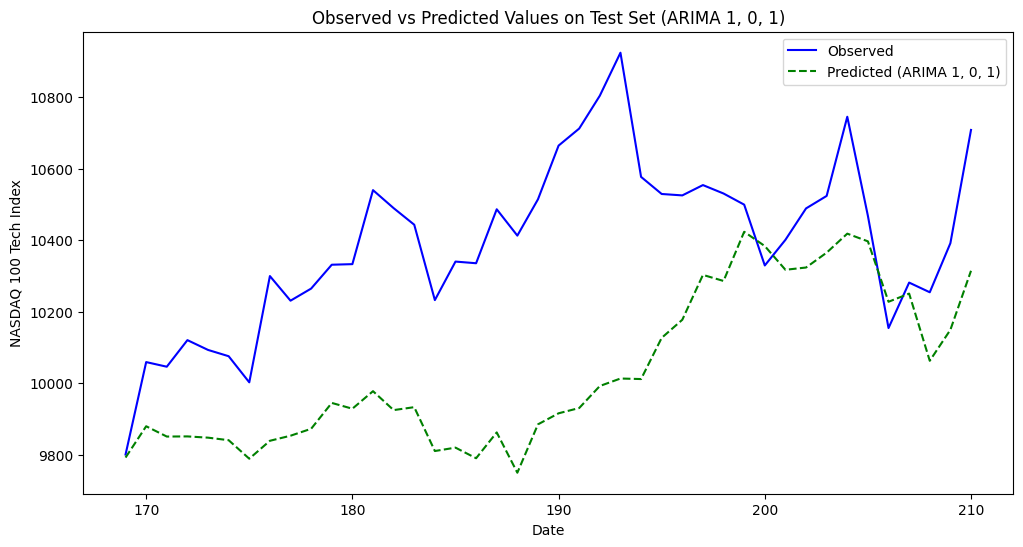

In [53]:
y_test_pred_101 = arima_101_fit.forecast(steps=len(y_test), exog=X_test)
test_mse_101 = mean_squared_error(y_test, y_test_pred_101)
print(f"Test Mean Squared Error (MSE) for ARIMA(1, 0, 1): {test_mse_101}")
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Observed', color='blue')
plt.plot(y_test.index, y_test_pred_101, label='Predicted (ARIMA 1, 0, 1)', color='green', linestyle='--')
plt.title('Observed vs Predicted Values on Test Set (ARIMA 1, 0, 1)')
plt.xlabel('Date')
plt.ylabel('NASDAQ 100 Tech Index')
plt.legend()
plt.show()